# Libraries

In [1]:
# import csv
# import os
# import re
import json
import umap

import hdbscan
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Dataset

In [10]:
# query = "Query_NYT_5y_surveillance"
query = "Query_NYT_13y_surveillance"
# query = "Query_US_5y_Svalbard"

FEATHER_FILE = query + ".feather"

df = pd.read_feather('data/' + FEATHER_FILE)
# df = df.drop(df[df['tags'].str.contains('None') == True].index)
# df = df.reset_index(drop=True)
df = df.drop('text_downloaded', axis=1)
df = df.drop('stories_id', axis=1)

df.sample()

,title,url,year,text,tags,GPE,IND,ORG
3159,SEARCH FOR WITNESSES WIDENS IN INQUIRY ON DAY-...,http://www.nytimes.com/1984/08/05/nyregion/sea...,2013,SEARCH FOR WITNESSES WIDENS IN INQUIRY ON DAY-...,"[{'label': 'children and youth', 'score': '0.4...","[Bronx, Bronx]","[Edward McCarthy, Mario Merola, O.K., Patrick ...","[ROBERT D. McFADDEN, Praca Day Care Center, th..."


## Tags

In [11]:
all_tags = []

for index, row in df.iterrows():

    tags = []

    for i, tag in enumerate(row["tags"]):
        if i < 3:
            tags.append(tag["label"])

    all_tags.append(tags)

df['TAG'] = all_tags
df = df.drop(columns=['tags'])

df.sample()

,title,url,year,text,GPE,IND,ORG,TAG
396,Barr Says House Subpoenaed Mueller to Create ‘...,https://www.nytimes.com/2019/07/08/us/politics...,2019,Supported by\nBarr Says House Subpoenaed Muell...,"[S.C., Russia, Edgefield, Russia, Russia, Russ...","[Barr, Subpoenaed Mueller, William P. Barr, Ro...","[House, House, Congress, Kremlin, the House Ju...","[politics and government, united states politi..."


## Entities

In [17]:
df = df[pd.to_numeric(df['year'], errors='coerce').notnull()] # Remove cells without integer
df = df.reset_index(drop=True)

print(set(df["year"].tolist()))

{'2018', '2021', '2010', '2011', '2017', '2016', '2022', '2020', '2023', '2014', '2012', '2013', '2015', '2019'}


In [23]:
entities = np.empty((0, 12), dtype=object)

years_template = {}

for year in sorted(set(df["year"].tolist())):
    print(year)
    years_template[year] = 0


def update(entity, type):  # Function for writing

    global entities
    co = cooccurrences.copy()
    co.remove(entity)
    index = np.where(entities[:, 0] == entity)[0]

    if index.size == 0:
        entities = np.append(
            entities,
            np.array(
                [
                    [
                        entity,
                        type,
                        1,
                        None,
                        None,
                        -1,
                        -1,
                        -1,
                        years_template.copy(),
                        [url],
                        [title],
                        co,
                    ]
                ],
                dtype=object,
            ),
            axis=0,
        )
        entities[len(entities) - 1][8][year] = 1  # Add year
    else:
        entities[index, 2] += 1  # Frequency
        entities[index, 8][0][year] += 1  # Year
        entities[index, 9][0].append(url)  # URL
        entities[index, 10][0].append(title)  # Title
        entities[index, 11][0] += co  # Co-occurrences


for index, row in df.iterrows():  # Iteration on all the articles

    url = row["url"]
    year = row["year"]
    title = row["title"]

    ind = row["IND"].tolist()
    org = row["ORG"].tolist()
    tag = row["TAG"]
    
    cooccurrences = list(ind + org + tag)

    for entity in ind:
        update(entity, "ind")

    for entity in org:
        update(entity, "org")

    for entity in tag:
        update(entity, "tag")


# Numpy to Pandas

entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        "x",
        "y",
        "cluster",
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset
entities_all = entities_all.astype(
    {
        "name": "str",
        "type": "str",
        "frequency": "int",
        "slope": "float",
        "color": "str",
        "x": "int",
        "y": "int",
        "cluster": "int",
        "years": "object",
        "urls": "object",
        "titles": "object",
        "cooccurrences": "object",
    }
)


print("The total number of entities is", len(entities))

entities_all.sort_values(by=["frequency"], ascending=False).head(1)

{'2022', '2021', '2016', '2019', '2011', '2023', '2018', '2020', '2010', '2017', '2012', None, '2015', '2014', '2013'}


SyntaxError: 'break' outside loop (3167693890.py, line 9)

# Treatment

## Normalization

In [30]:
# Frequency scale

frequency = entities_all["frequency"].to_numpy().reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
entities_all["frequency_norm"] = frequency_scaled

# Transfrom dictionary into JSON

for index, row in entities_all.iterrows():
    entities_all.loc[index, "years_JSON"] = json.dumps(row["years"])

entities_all.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
5936,Hublot x Eden Rock St Barths,org,1,NaN,None,-1,-1,-1,"{'2018': 0, '2019': 0, '2020': 1, '2021': 0, '...",[https://www.forbes.com/sites/angelinavillacla...,[The Companies Bringing Travel Home To You Thi...,"[Devold, Rothschild, Newt, Newt, Newt, Babylon...",0.0,"{""2018"": 0, ""2019"": 0, ""2020"": 1, ""2021"": 0, ""..."


## Filter

In [31]:
# Number of rows by type

# max_subjects = 1000
# max_orgs = 1000
# max_people = 1000

# top_subjects = (
#     entities_all.loc[entities_all["type"] == "subject"]
#     .sort_values(by=["frequency"], ascending=False)
#     .head(max_subjects)
# )
# top_orgs = (
#     entities_all.loc[entities_all["type"] == "org"]
#     .sort_values(by=["frequency"], ascending=False)
#     .head(max_orgs)
# )
# top_people = (
#     entities_all.loc[entities_all["type"] == "person"]
#     .sort_values(by=["frequency"], ascending=False)
#     .head(max_people)
# )

# entities = pd.concat([top_subjects, top_orgs, top_people])

min_frequency = 15

entities = (
    entities_all[entities_all['frequency']>min_frequency]
    .sort_values(by=["frequency"], ascending=False)
)

len(entities)


269

In [32]:
entities.head(3)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
50,Svalbard,org,1162,NaN,None,-1,-1,-1,"{'2018': 7, '2019': 197, '2020': 247, '2021': ...",[https://www.zdnet.com/article/the-worlds-most...,[The world's most important cold storage facil...,"[Åsmund Asdal, NordGen, TechRepublic, Tech Pro...",1.000000,"{""2018"": 7, ""2019"": 197, ""2020"": 247, ""2021"": ..."
1235,EU,org,204,NaN,None,-1,-1,-1,"{'2018': 0, '2019': 2, '2020': 6, '2021': 128,...",[http://theconversation.com/mass-starvation-of...,[Mass starvation of reindeer linked to climate...,"[Yamal, Shrubby, Sapmi, weather, global warmin...",0.174849,"{""2018"": 0, ""2019"": 2, ""2020"": 6, ""2021"": 128,..."
55,global warming,tag,194,NaN,None,-1,-1,-1,"{'2018': 1, '2019': 35, '2020': 50, '2021': 21...",[https://www.zdnet.com/article/the-worlds-most...,[The world's most important cold storage facil...,"[Åsmund Asdal, NordGen, TechRepublic, Tech Pro...",0.166236,"{""2018"": 1, ""2019"": 35, ""2020"": 50, ""2021"": 21..."


## Linear Regression

In [71]:
# For each entity

for i, row in entities.iterrows():

    x = list(row["years"].keys()) # Extract years
    x = [int(numeric_string) for numeric_string in x] # Set to int
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row["years"].values()) # Extract frequency
    y = np.array(y) # To Numpy (code works without this line)

    regression = LinearRegression()
    regression.fit(x, y)
    
    entities.at[i, "slope"] = regression.coef_[0] # compute linear regression


# normalization by type

# scale = 1

# for type in entities["type"].unique():

#     selection = entities.loc[entities["type"] == type]
#     mean = selection["slope"].mean() * scale
    
#     for i, row in selection.iterrows():
#         entities.at[i, "slope"] = row["slope"] - mean


entities.sample()


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
8362,Sumner,ind,16,0.457143,None,-1,-1,-1,"{'2018': 0, '2019': 0, '2020': 0, '2021': 16, ...",[https://theweek.com/culture/entertainment/100...,[<i>The North Water</i> and the case for nauti...,"[Gilligan, Ian McGuire's, Andrew Haigh, Joseph...",0.01292,"{""2018"": 0, ""2019"": 0, ""2020"": 0, ""2021"": 16, ..."


## Colors

In [73]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():

    if row["type"] == "tag":
        entities.at[i, "color"] = "#cccccc"
    else:
        entities.at[i, "color"] = mcolors.to_hex(cmap(norm(row["slope"])))  # Actors

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
50,Svalbard,org,1162,50.114286,#b40426,-1,-1,-1,"{'2018': 7, '2019': 197, '2020': 247, '2021': ...",[https://www.zdnet.com/article/the-worlds-most...,[The world's most important cold storage facil...,"[Åsmund Asdal, NordGen, TechRepublic, Tech Pro...",1.0,"{""2018"": 7, ""2019"": 197, ""2020"": 247, ""2021"": ..."


# Embedding

## Term Frequency

In [74]:
vectorizer = CountVectorizer(
    input="content",
    lowercase=False,
    # preprocessor=lambda x: x,
    tokenizer=lambda key: key,
)
words = entities["cooccurrences"].to_list()
X = vectorizer.fit_transform(words)

tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## UMAP

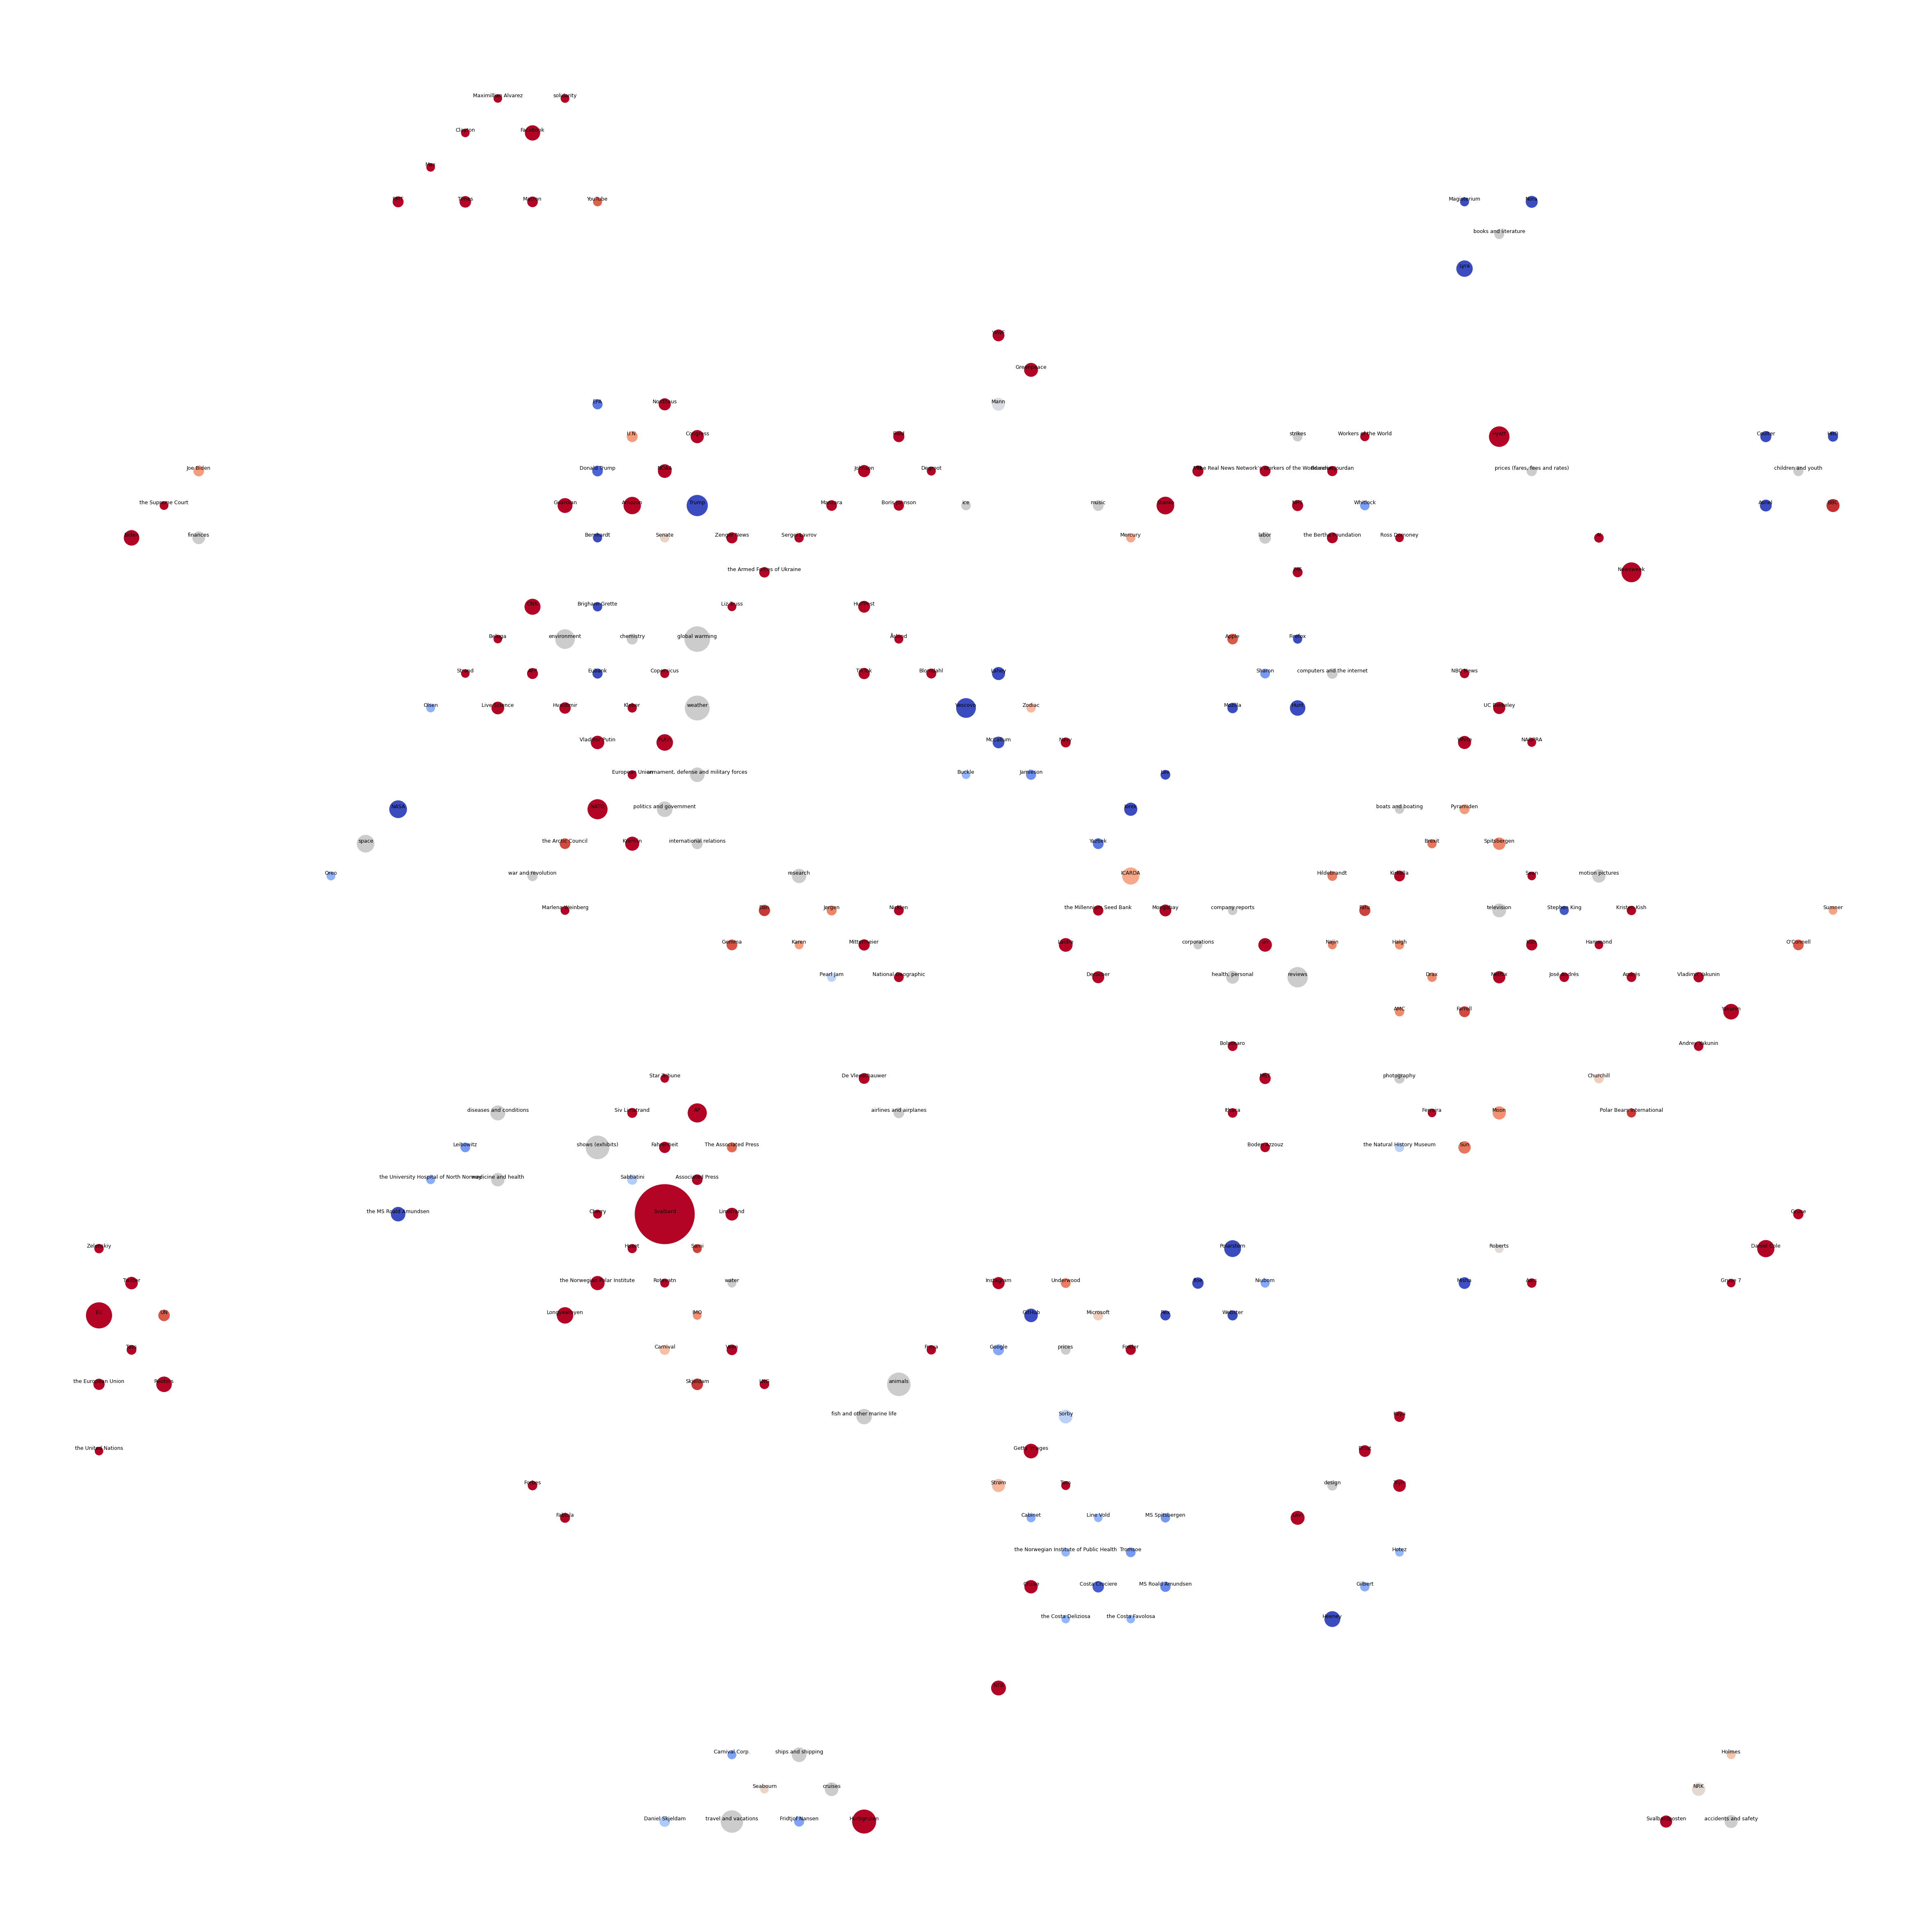

In [75]:
reducer = umap.UMAP(
    random_state=4,
    n_components=2,
    n_neighbors=2,
    min_dist=0.2,
    metric="hellinger",
)

embedding = reducer.fit_transform(train_data)  # Reducer
embedding = align_points_to_grid(embedding)  # Alignment to a grid

scaler = MinMaxScaler(feature_range=(100, 900))  # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding.astype(int)

index_embedding = 0  # Writing values in the dataset
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

# entities.sample(1)

plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    entities["x"].to_list(),
    entities["y"].to_list(),
    s=entities["frequency"].to_list(),
    c=entities["color"].to_list(),
)

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")


## Clustering

In [76]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=3,
    min_cluster_size=4,
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=10, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

entities["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, entities):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            entities.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            entities.loc[index, "cluster"] = str(clusters[count])


cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] > 0)],
    "p_",
    entities,
)
cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] < 0)],
    "n_",
    entities,
)

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
3529,Sorby,org,48,-0.228571,#bbd1f8,546,288,n_0,"{'2018': 0, '2019': 0, '2020': 28, '2021': 20,...",[https://www.pri.org/stories/2020-04-06/tips-s...,[Tips to survive self-isolation from citizen s...,"[Sunniva Sorby, Hilde Fålulm Strøm, Strom, the...",0.040482,"{""2018"": 0, ""2019"": 0, ""2020"": 28, ""2021"": 20,..."


{'n_3', 'p_0', 'p_3', 'n_1', 'n_0', 'p_2', 'n_2', 'p_1', '-1'}
44
9
10
8
6
13
8
8
42


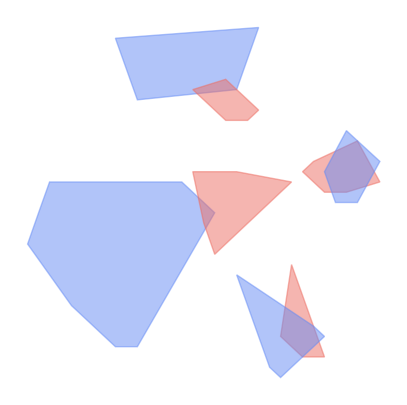

In [23]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(entities["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = entities.loc[entities["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#ED6D62", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#648BF5", alpha=0.5)  # Plot blue


# Save

In [77]:
export = entities.copy()

export = export.drop(columns="years")
export = export.drop(columns="titles")
export = export.drop(columns="cooccurrences")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)


,name,type,frequency,slope,color,x,y,cluster,urls,frequency_norm,years_JSON
10100,The Real News Network’s Workers of the World s...,org,28,3.885714,#b40426,638,727,p_7,[https://therealnews.com/uk-rail-workers-prepa...,0.023256,"{""2018"": 0, ""2019"": 0, ""2020"": 0, ""2021"": 0, ""..."
